In [1]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

import shelve
import torch
import numpy as np

from DatasetWrapper import *
import os
import inspect
import sys

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
#parentdir = os.path.dirname(currentdir)
#parentdir = os.path.dirname(parentdir)
#sys.path.insert(0, os.path.join(parentdir,"graph_generation"))
#sys.path.insert(0, parentdir)

In [3]:
import sys
sys.path.append('../../')

In [4]:
from graph_generation import MultiGraphs

In [5]:
multi_dataset = MultiGraphs.MultiGraphs(1000).getDataset()

In [6]:
dataset = DatasetWrapper(multi_dataset, num_cls=3)

In [7]:
model = GCNClassifier(node_features=3,
                            num_classes=3,
                            hidden_channels=16,
                            num_layers=3)
model.load_state_dict(torch.load('ckpts/multi.pt'))

<All keys matched successfully>

In [8]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9200000166893005,
 'cm': array([[310,  12,  12],
        [  4, 322,   7],
        [  6,  39, 288]], dtype=int64),
 'f1': {0: 0.9480122327804565, 1: 0.9121813178062439, 2: 0.8999999761581421}}

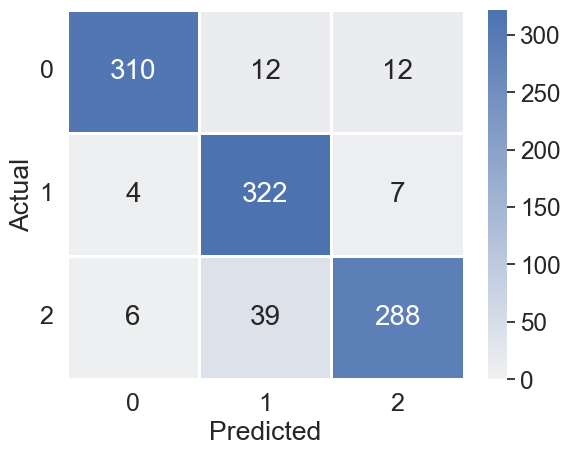

In [10]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [11]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


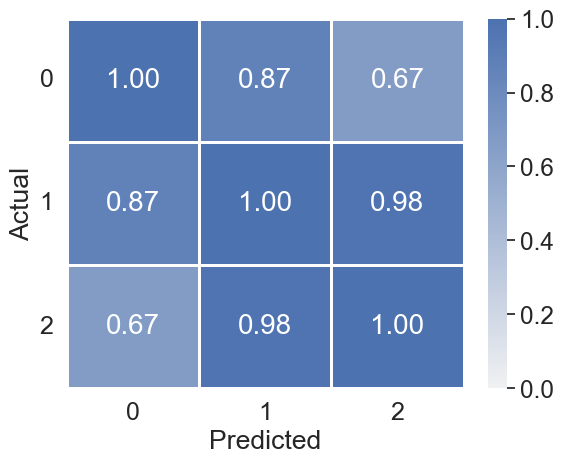

In [12]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [13]:
trainer = {}
sampler = {}

In [14]:
from gnn_boundary import Trainer

In [22]:
cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.5,
        num_node_cls=3,#len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=3, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=0.03)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [23]:
trainer[0, 1].train(
    iterations=20000,
    target_probs={cls_1: (0.45, 0.6), cls_2: (0.45, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16*2
)

  3%|▎         | 560/20000 [00:17<09:56, 32.58it/s]


True

n=22 m=15
logits=[0.5847554802894592, 0.6190587282180786, -2.215108633041382]
probs=[0.47716373205184937, 0.49381598830223083, 0.029020296409726143]


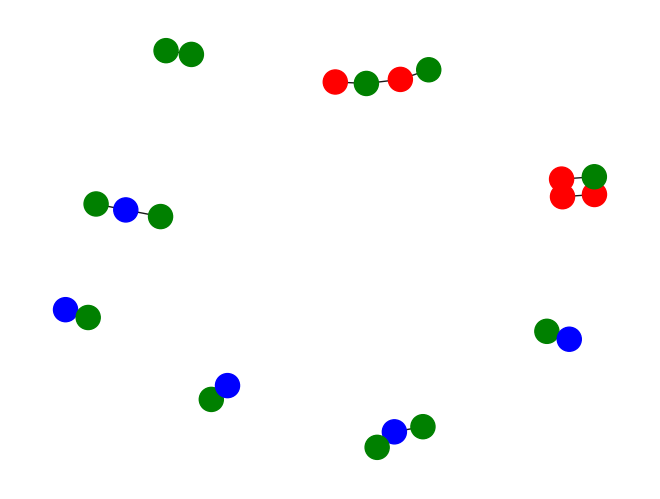

In [24]:
test = trainer[0, 1].evaluate(threshold=0.5, show=True)

In [25]:
data = dataset.convert(test,generate_label=True)

In [26]:
model(data)

{'logits': tensor([[ 0.5848,  0.6191, -2.2151]], grad_fn=<AddmmBackward0>),
 'probs': tensor([[0.4772, 0.4938, 0.0290]], grad_fn=<SoftmaxBackward0>),
 'embeds': tensor([[ 1.0819e+00, -2.0511e+00, -2.4699e+00,  5.4068e+00, -3.6198e+00,
          -3.6392e+00,  1.4761e+00, -5.0901e+00,  2.9315e-01,  1.9159e+00,
           4.3655e+00,  7.6146e-02, -7.8175e-01, -5.1848e+00,  2.5385e+00,
           1.3251e+00,  4.9175e-02, -9.3233e-02, -1.1227e-01,  2.4577e-01,
          -1.6454e-01, -1.6542e-01,  6.7096e-02, -2.3137e-01,  1.3325e-02,
           8.7085e-02,  1.9843e-01,  3.4612e-03, -3.5534e-02, -2.3567e-01,
           1.1538e-01,  6.0230e-02]], grad_fn=<CatBackward0>),
 'embeds_last': tensor([[3.6665, 0.0000, 0.0000, 2.0014, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.5506, 4.3657, 3.5727, 0.0000, 0.0000, 0.0000]],
        grad_fn=<ReluBackward0>)}

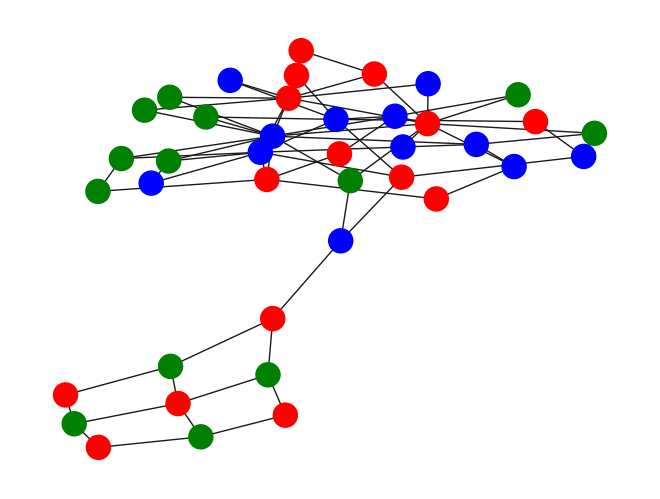

In [29]:
dataset.draw(dataset[0].G)

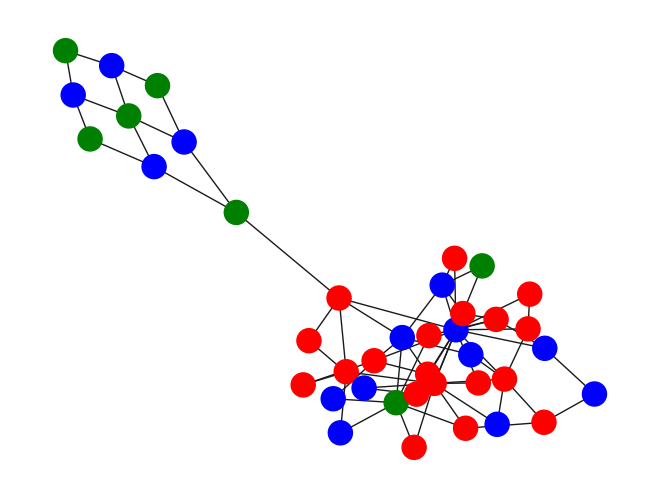

In [30]:
dataset.draw(dataset[1].G)

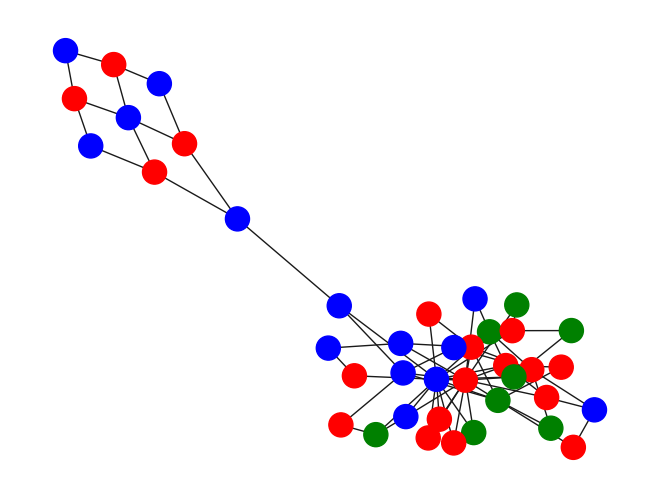

In [31]:
dataset.draw(dataset[2].G)